In [1]:
%config StoreMagics.autorestore = True
%reset -f
# %store -z
%store -r
%whos

Variable           Type              Data/Info
----------------------------------------------
dvMathcalP         LinearIOSystem    <LinearIOSystem>: sys[122<...>[[0. 0.]\n     [0. 0.]]\n
extMathcalP        LinearIOSystem    <LinearIOSystem>: sys[121<...> [0. 0.]\n     [0. 0.]]\n
fullOrder          int               80
hsvDvMathcalP      ndarray           80: 80 elems, type `float64`, 640 bytes
hsvExtMathcalP     ndarray           80: 80 elems, type `float64`, 640 bytes
idx_results_list   list              n=1800
mathcalP_cb        LinearIOSystem    <LinearIOSystem>: sys[6]\<...>[[0. 0.]\n     [0. 0.]]\n
reducOrder         int               5
truncDvMathcalP    LinearIOSystem    <LinearIOSystem>: sys[124<...>[[0. 0.]\n     [0. 0.]]\n
truncExtMathcalP   LinearIOSystem    <LinearIOSystem>: sys[123<...> [0. 0.]\n     [0. 0.]]\n


In [2]:
import numpy
import sympy
import scipy
import control
import matplotlib.pyplot as plt

from custom_utils import ControlUtils
from custom_utils import ODEUtils

from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML

numpy.set_printoptions(precision=3)
sympy.init_printing(use_latex='mathjax', use_unicode=True)
sympy.init_printing()
plt.rcParams.update({ "text.usetex": True, "font.family": "Helvetica", "axes.titley": 1.0 })
%matplotlib inline

(array([1.010e+00, 1.010e+00, 1.010e+00, ..., 1.035e-11, 1.017e-11,
        1.000e-11]),
 array([-0.01 , -0.01 , -0.01 , ..., -4.711, -4.711, -4.711]),
 array([1.000e+01, 1.006e+01, 1.012e+01, ..., 9.885e+05, 9.943e+05,
        1.000e+06]))

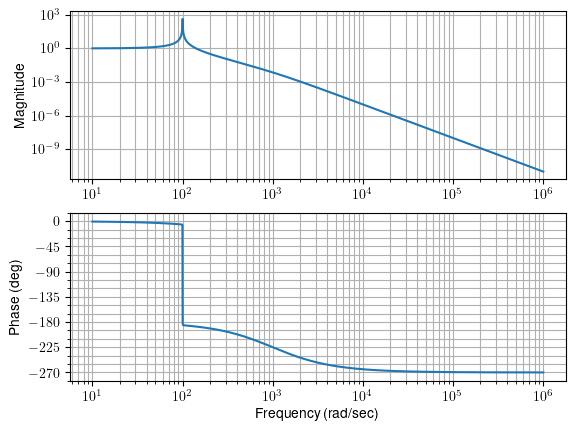

In [20]:
# Plant creation
extMathcalPcl = control.zpk([],[-0.01 + 100j, -0.01 - 100j, -1000], 10e6)
omega = numpy.logspace(1,6,2000)
control.bode(extMathcalPcl,omega=omega)

# Controller creation


In [4]:

# Simulation parameters
Tsam = 0.1
T_step = Tsam/1000
t_ini = 0
t_fin = 5
steps = int(numpy.ceil((t_fin-t_ini)/T_step))



tkVec = numpy.arange(t_ini, t_fin, Tsam)[:, None]
tVec = numpy.linspace(t_ini, t_fin, steps)[:, None]
# uVec = 1e-4*numpy.sin(2*numpy.pi*tVec/0.1)
uVec = 1*numpy.sin(15*tVec)
zerosVec = 0*numpy.zeros((steps,1))


In [12]:
# FOM
resultFOM = control.input_output_response(extMathcalPcl, tVec.reshape(-1),numpy.column_stack([zerosVec,uVec]).T,\
                                        numpy.zeros((extMathcalPcl.A.shape[0],1)),t_eval=tVec.reshape(-1))

In [13]:
# ROM
resultROM = control.input_output_response(truncExtMathcalPcl, tVec.reshape(-1),numpy.column_stack([zerosVec,uVec]).T,\
                                        numpy.zeros((truncExtMathcalPcl.A.shape[0],1)),t_eval=tVec.reshape(-1))

In [14]:
# Sampled FOM
xpVecFOM, xcVecFOM, vsVecFOM, whVecFOM = ODEUtils.solveSDLinearSystem(plant=extMathcalP,
                                                          discrete_controller=overlineMathcalC,
                                                          xp0=0*numpy.random.rand(*(extMathcalP.A.shape[0], 1)),
                                                          xc0=0*numpy.random.rand(*(overlineMathcalC.A.shape[0], 1)),
                                                          uVec=uVec, t_ini=t_ini, t_fin=t_fin, T_step=T_step, T_samps=tkVec)

In [15]:
# Sampled ROM
xpVecROM, xcVecROM, vsVecROM, whVecROM = ODEUtils.solveSDLinearSystem(plant=truncExtMathcalP,
                                                          discrete_controller=overlineMathcalC,
                                                          xp0=0*numpy.random.rand(*(truncExtMathcalP.A.shape[0], 1)),
                                                          xc0=0*numpy.random.rand(*(overlineMathcalC.A.shape[0], 1)),
                                                          uVec=uVec, t_ini=t_ini, t_fin=t_fin, T_step=T_step, T_samps=tkVec)

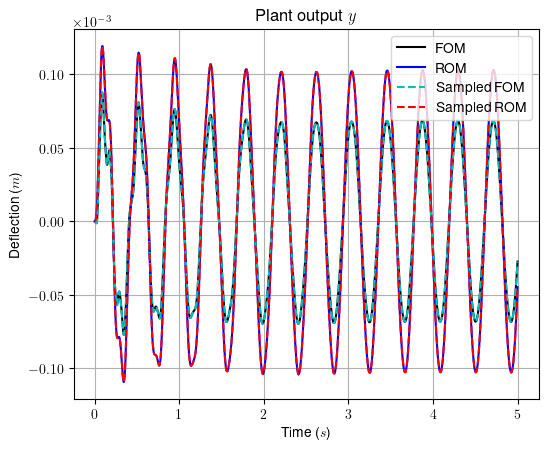

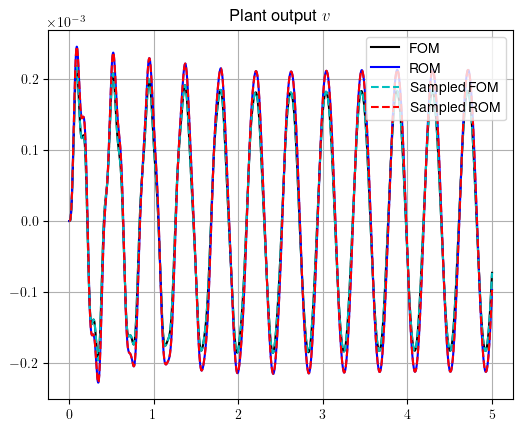

In [16]:
# Compute outputs
tLims = [t_ini,t_fin]
idxLims = range(numpy.where(tVec[:, 0] >= tLims[0])[0][0], numpy.where(tVec[:, 0] >= tLims[1])[0][0] + 1)

yVecFOM = resultFOM.outputs[2][:,None].T
vVecFOM = resultFOM.outputs[0][:,None].T

yVecROM = resultROM.outputs[2][:,None].T
vVecROM = resultROM.outputs[0][:,None].T

yVecSampledFOM = extMathcalP.C[-1:,:] @ xpVecFOM
vVecSampledFOM = extMathcalP.C[0:1,:] @ xpVecFOM

yVecSampledROM = truncExtMathcalP.C[-1:,:] @ xpVecROM
vVecSampledROM = truncExtMathcalP.C[0:1,:] @ xpVecROM

plt.plot(tVec[idxLims, 0], yVecFOM[0, idxLims], 'k', label="FOM", linestyle='solid')
plt.plot(tVec[idxLims, 0], yVecROM[0, idxLims], 'b', label="ROM", linestyle='solid')
plt.plot(tVec[idxLims, 0], yVecSampledFOM[0, idxLims], 'c', label="Sampled FOM", linestyle='dashed')
plt.plot(tVec[idxLims, 0], yVecSampledROM[0, idxLims], 'r', label="Sampled ROM", linestyle='dashed')
plt.ticklabel_format(axis='y', scilimits=(-3,-3))
plt.title('Plant output $y$')
plt.ylabel('Deflection ($m$)')
plt.xlabel('Time ($s$)')
plt.legend(loc='upper right')
plt.grid()
plt.gcf().set_figwidth(6)
plt.show()
        
plt.plot(tVec[idxLims, 0], vVecFOM[0, idxLims], 'k', label="FOM", linestyle='solid')
plt.plot(tVec[idxLims, 0], vVecROM[0, idxLims], 'b', label="ROM", linestyle='solid')
plt.plot(tVec[idxLims, 0], vVecSampledFOM[0, idxLims], 'c', label="Sampled FOM", linestyle='dashed')
plt.plot(tVec[idxLims, 0], vVecSampledROM[0, idxLims], 'r', label="Sampled ROM", linestyle='dashed')
plt.ticklabel_format(axis='y', scilimits=(-3,-3))
plt.title('Plant output $v$')
plt.legend(loc='upper right')
plt.grid()
plt.gcf().set_figwidth(6)
plt.show()
